In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
df = pd.read_csv("train_imputed.csv", index_col=0)

In [3]:
df.shape

(1460, 80)

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000000,8450,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,No_FP,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,No_Pool,No_Fence,No_MF,0,2,2008,WD,Normal,208500
2,20,RL,80.000000,9600,Pave,No_Alley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,No_Pool,No_Fence,No_MF,0,5,2007,WD,Normal,181500
3,60,RL,68.000000,11250,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,No_Pool,No_Fence,No_MF,0,9,2008,WD,Normal,223500
4,70,RL,60.000000,9550,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,No_Pool,No_Fence,No_MF,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000000,14260,Pave,No_Alley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,No_Pool,No_Fence,No_MF,0,12,2008,WD,Normal,250000
6,50,RL,85.000000,14115,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,No_FP,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,No_Pool,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.000000,10084,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,No_Pool,No_Fence,No_MF,0,8,2007,WD,Normal,307000
8,60,RL,71.002296,10382,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,No_Pool,No_Fence,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.000000,6120,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,

## Box-Cox Transformation


 mu = 180921.20 and sigma = 79415.29



Text(0.5, 0.98, 'Before transformation')

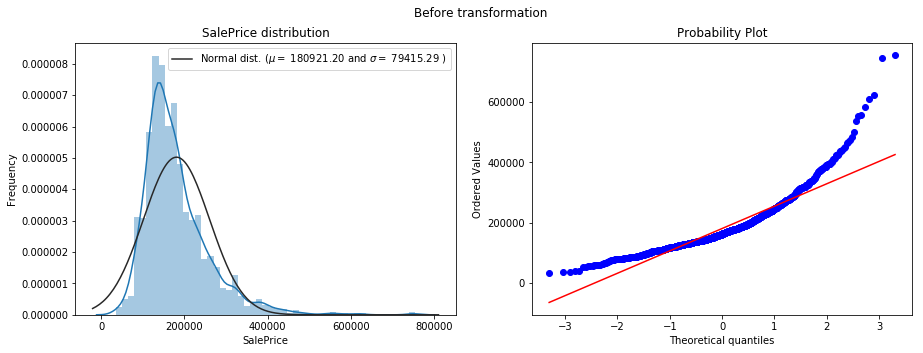

In [5]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['SalePrice'], plot=plt)
plt.suptitle('Before transformation')

In [6]:
# Apply transformation
df.SalePrice = np.log1p(df.SalePrice )
# New prediction
y_train = df.SalePrice.values
y_train_orig = df.SalePrice


 mu = 12.02 and sigma = 0.40



Text(0.5, 0.98, 'After transformation')

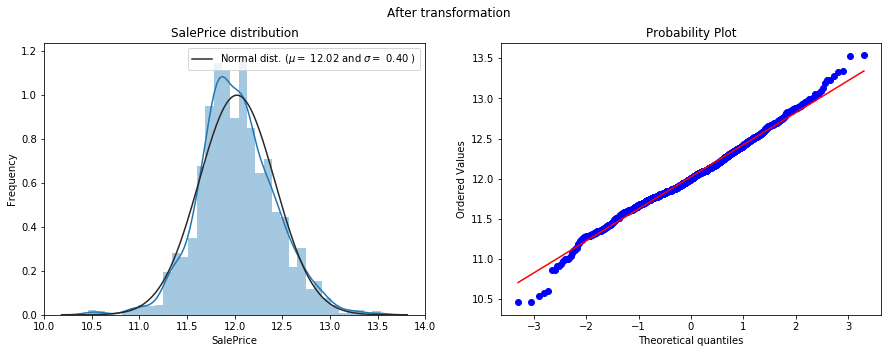

In [7]:
# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['SalePrice'], plot=plt)
plt.suptitle('After transformation')

# Feature Engineering

In [8]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)
numerical_features = df.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
feat_num = df[numerical_features]
feat_cat = df[categorical_features]

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'], dtype='object')
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDe

In [9]:
feat_num.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.000000,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,12.247699
2,20,80.000000,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,12.109016
3,60,68.000000,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,12.317171
4,70,60.000000,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,11.849405
5,60,84.000000,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,12.429220
6,50,85.000000,14115,5,5,1993,1995,0.0,732,0,64,796,796,566,0,1362,1,0,1,1,1,1,5,0,1993.0,2,480,40,30,0,320,0,0,700,10,2009,11.870607
7,20,75.000000,10084,8,5,2004,2005,186.0,1369,0,317,1686,1694,0,0,1694,1,0,2,0,3,1,7,1,2004.0,2,636,255,57,0,0,0,0,0,8,2007,12.634606
8,60,71.002296,10382,7,6,1973,1973,240.0,859,32,216,1107,1107,983,0,2090,1,0,2,1,3,1,7,2,1973.0,2,484,235,204,228,0,0,0,350,11,2009,12.206078
9,50,51.000000,6120,7,5,1931,1950,0.0,0,0,952,952,1022,752,0,1774,0,0,2,0,2,2,8,2,1931.0,2,468,90,0,205,0,0,0,0,4,2008,11.774528


In [10]:
feat_cat.head(10)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,No_FP,Attchd,RFn,TA,TA,Y,No_Pool,No_Fence,No_MF,WD,Normal
2,RL,Pave,No_Alley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,No_Pool,No_Fence,No_MF,WD,Normal
3,RL,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,No_Pool,No_Fence,No_MF,WD,Normal
4,RL,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,No_Pool,No_Fence,No_MF,WD,Abnorml
5,RL,Pave,No_Alley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,No_Pool,No_Fence,No_MF,WD,Normal
6,RL,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,Wood,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,No_FP,Attchd,Unf,TA,TA,Y,No_Pool,MnPrv,Shed,WD,Normal
7,RL,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,Stone,Gd,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,No_Pool,No_Fence,No_MF,WD,Normal
8,RL,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,Gable,CompShg,HdBoard,HdBoard,Stone,TA,TA,CBlock,Gd,TA,Mn,ALQ,BLQ,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,No_Pool,No_Fence,Shed,WD,Normal
9,RM,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,Gable,CompShg,BrkFace,Wd Shng,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,GasA,Gd,Y,FuseF,TA,Min1,TA,Detchd,Unf,Fa,TA,Y,No_Pool,No_Fence,No_MF,WD,Abnorml


In [11]:
# Adding new df .

#df['YrBltAndRemod']=df['YearBuilt']+df['YearRemodAdd']
df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                                 df['1stFlrSF'] + df['2ndFlrSF'])

df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

In [12]:
## For ex, if PoolArea = 0 , Then HasPool = 0 too

df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [13]:
df.shape

(1460, 89)

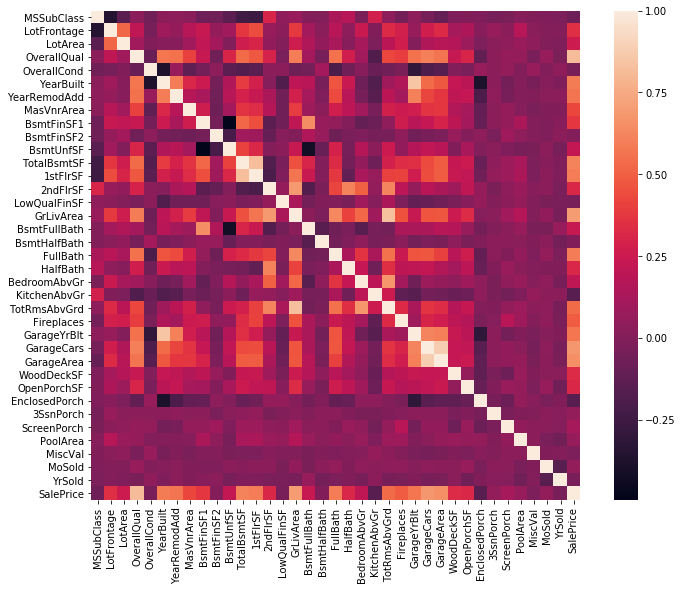

In [14]:
# Complete numerical correlation matrix
corrmat = feat_num.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

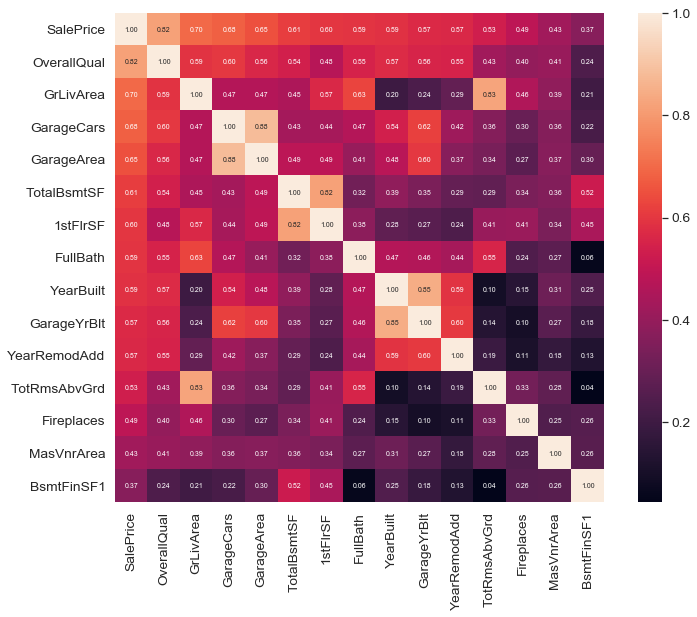

In [17]:
# saleprice correlation matrix
corr_num = 15 #number of variables for heatmap
cols_corr = corrmat.nlargest(corr_num, 'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(feat_num[cols_corr].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(corr_mat_sales, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols_corr.values, xticklabels=cols_corr.values)
plt.show()

# Dummification

In [18]:
df2 = pd.get_dummies(df).reset_index(drop=True)
df2.shape

(1460, 313)

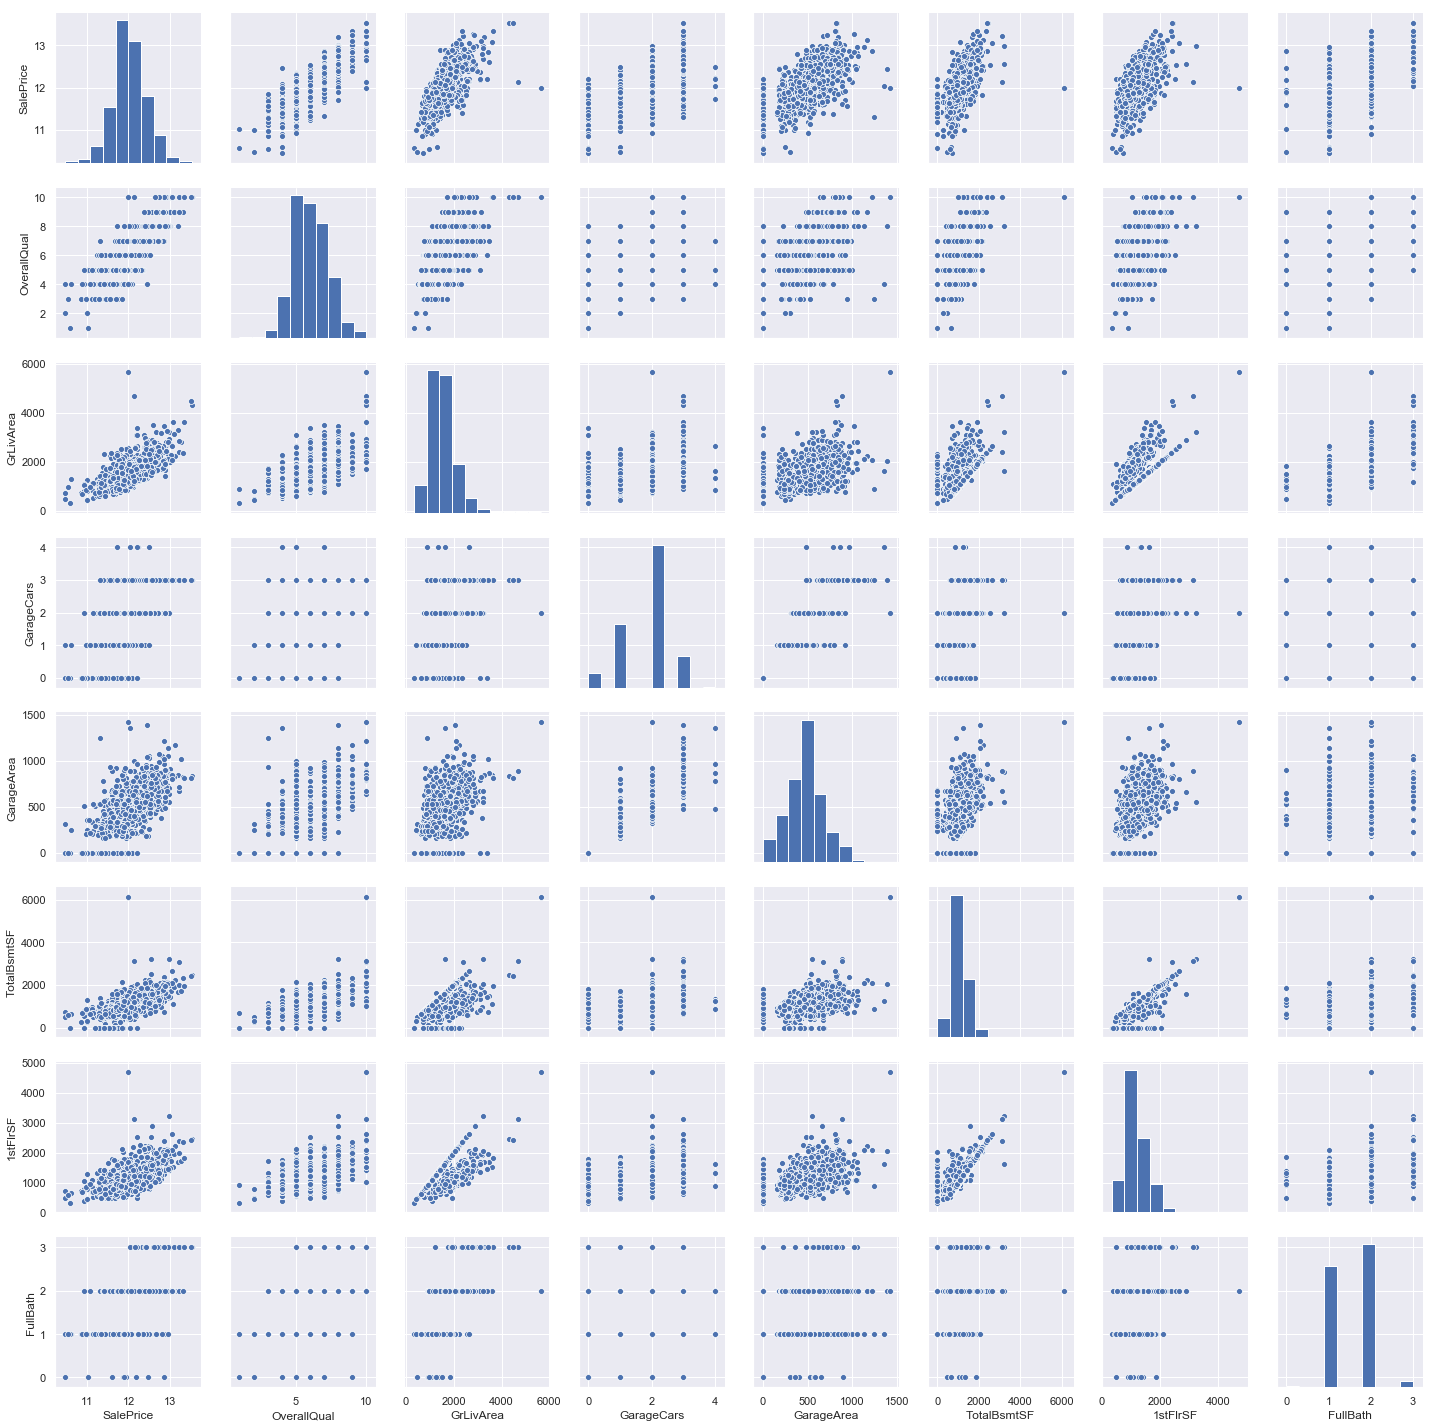

In [19]:
# pair plots for variables with largest correlation
var_num = 8
vars = cols_corr[0:var_num]

sns.set()
sns.pairplot(df2[vars], height = 2.5)
plt.show();

In [20]:
seed = 46
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [21]:
lr = LinearRegression(n_jobs = -1)
lasso = Lasso(random_state = seed)
ridge = Ridge(random_state = seed)
elnt = ElasticNet(random_state = seed)

In [22]:
def train_r2(model):
    model.fit(df2, y_train)
    return model.score(df2, y_train)

In [23]:
models = [lr, lasso, ridge, elnt]
training_score = []
for model in models:
    training_score.append(train_r2(model))

In [24]:
training_score

[1.0, 0.7688141872111058, 0.999785734461281, 0.7883454339138417]


 mu = 6.10 and sigma = 1.38



Text(0.5, 0.98, 'Before transformation')

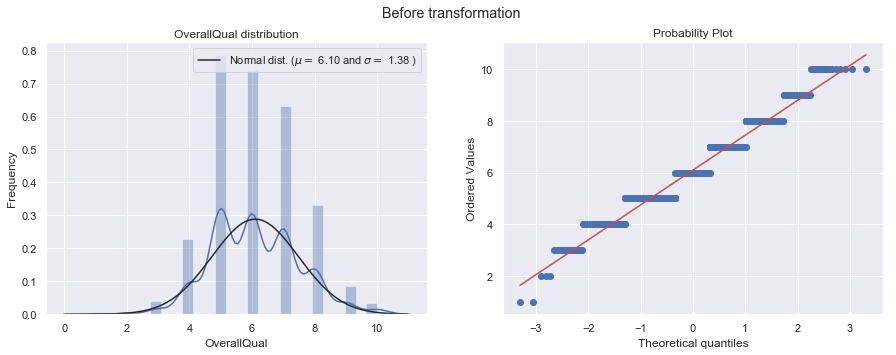

In [25]:
# Testing x Transformation: Overall Quality
from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['OverallQual'] , fit=norm);
(mu, sigma) = norm.fit(df['OverallQual'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('OverallQual distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['OverallQual'], plot=plt)
plt.suptitle('Before transformation')

In [26]:
# Apply transformation
df.OverallQual = np.log1p(df.OverallQual )


 mu = 1.94 and sigma = 0.20



Text(0.5, 0.98, 'After transformation')

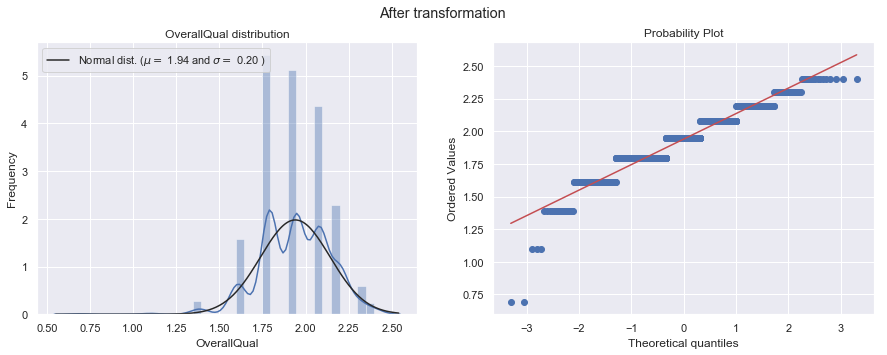

In [27]:
# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['OverallQual'] , fit=norm);
(mu, sigma) = norm.fit(df['OverallQual'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('OverallQual distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['OverallQual'], plot=plt)
plt.suptitle('After transformation')


 mu = 1.77 and sigma = 0.75



Text(0.5, 0.98, 'Before transformation')

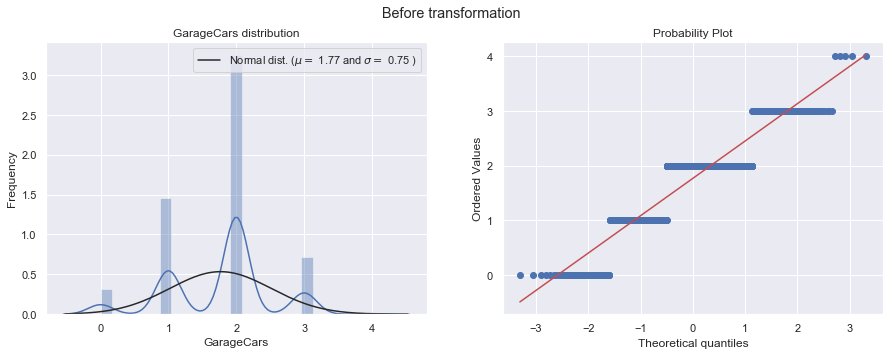

In [28]:
# Testing x Transformation: Garage Cars

from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['GarageCars'] , fit=norm);
(mu, sigma) = norm.fit(df['GarageCars'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GarageCars distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['GarageCars'], plot=plt)
plt.suptitle('Before transformation')

In [29]:
df.GarageCars = np.log1p(df.GarageCars)


 mu = 0.66 and sigma = 0.20



Text(0.5, 0.98, 'After transformation')

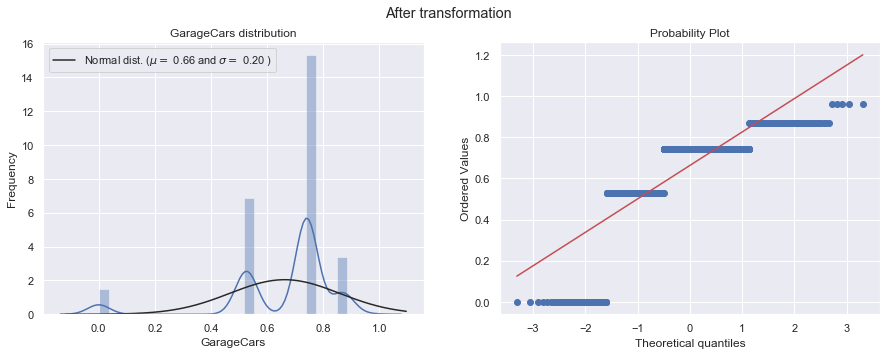

In [56]:
# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['GarageCars'] , fit=norm);
(mu, sigma) = norm.fit(df['GarageCars'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GarageCars distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['GarageCars'], plot=plt)
plt.suptitle('After transformation')


 mu = 1515.46 and sigma = 525.30



Text(0.5, 0.98, 'Before transformation')

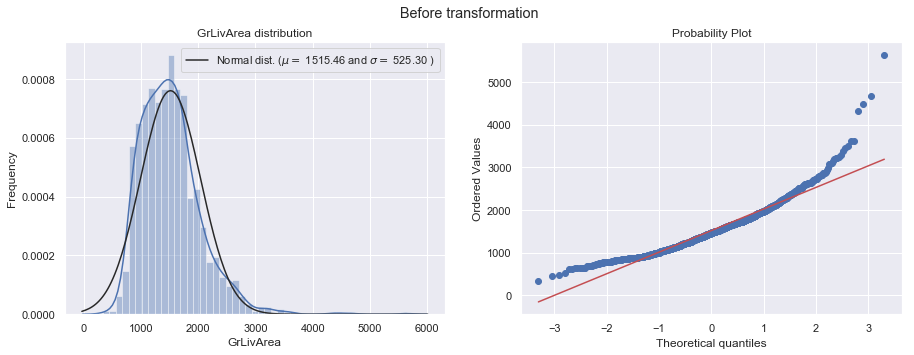

In [30]:
# Testing x Transformation: GrLivArea

from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['GrLivArea'] , fit=norm);
(mu, sigma) = norm.fit(df['GrLivArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GrLivArea distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['GrLivArea'], plot=plt)
plt.suptitle('Before transformation')

In [31]:
df.GrLivArea = np.log1p(df.GrLivArea)



 mu = 7.27 and sigma = 0.33



Text(0.5, 0.98, 'After transformation')

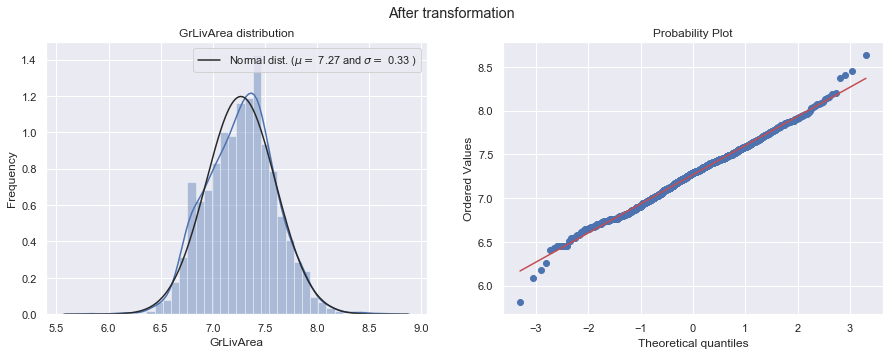

In [32]:
# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['GrLivArea'] , fit=norm);
(mu, sigma) = norm.fit(df['GrLivArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GrLivArea distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['GrLivArea'], plot=plt)
plt.suptitle('After transformation')


 mu = 472.98 and sigma = 213.73



Text(0.5, 0.98, 'Before transformation')

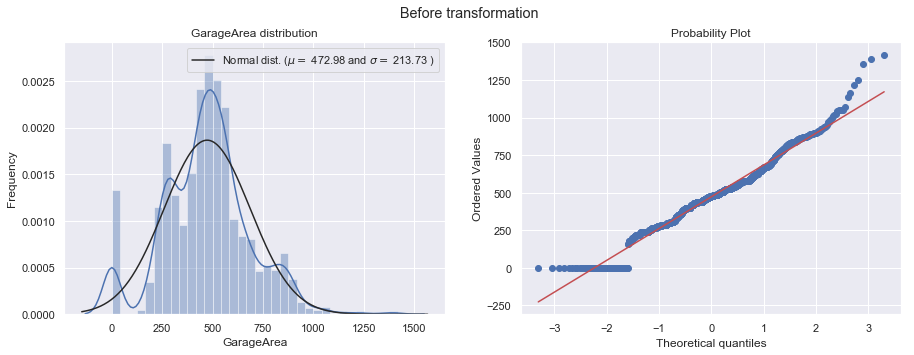

In [60]:
# Testing x Transformation: Garage Area

from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['GarageArea'] , fit=norm);
(mu, sigma) = norm.fit(df['GarageArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GarageArea distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['GarageArea'], plot=plt)
plt.suptitle('Before transformation')

In [33]:
df.GarageArea = np.log1p(df.GarageArea)



 mu = 5.81 and sigma = 1.45



Text(0.5, 0.98, 'After transformation')

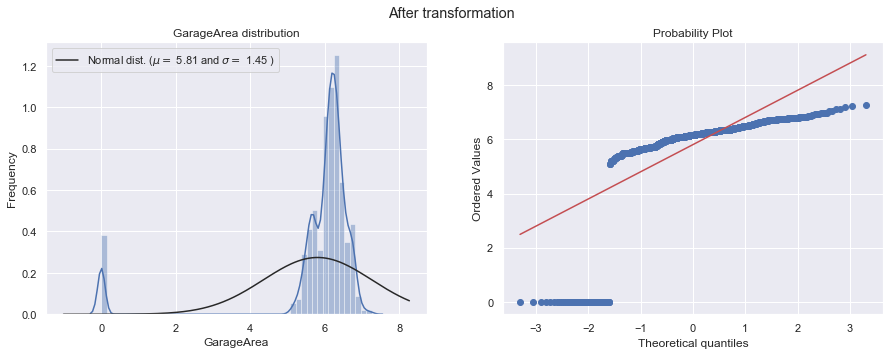

In [34]:
# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['GarageArea'] , fit=norm);
(mu, sigma) = norm.fit(df['GarageArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GarageArea distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['GarageArea'], plot=plt)
plt.suptitle('After transformation')


 mu = 1057.43 and sigma = 438.56



Text(0.5, 0.98, 'Before transformation')

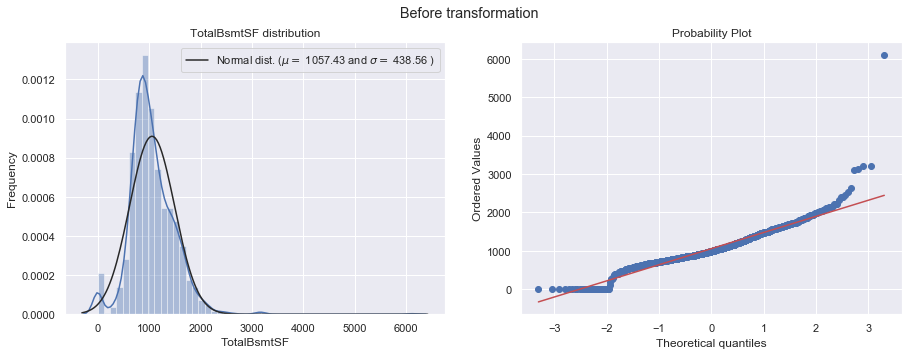

In [35]:
# Testing x Transformation: TotalBsmtSF

from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['TotalBsmtSF'] , fit=norm);
(mu, sigma) = norm.fit(df['TotalBsmtSF'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('TotalBsmtSF distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['TotalBsmtSF'], plot=plt)
plt.suptitle('Before transformation')

In [36]:
df.TotalBsmtSF = np.log1p(df.TotalBsmtSF)



 mu = 6.75 and sigma = 1.15



Text(0.5, 0.98, 'After transformation')

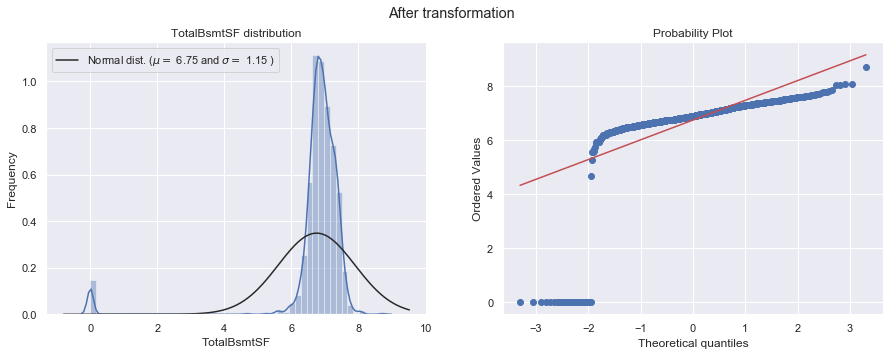

In [37]:

# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['TotalBsmtSF'] , fit=norm);
(mu, sigma) = norm.fit(df['TotalBsmtSF'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('TotalBsmtSF distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['TotalBsmtSF'], plot=plt)
plt.suptitle('After transformation')



 mu = 1.57 and sigma = 0.55



Text(0.5, 0.98, 'Before transformation')

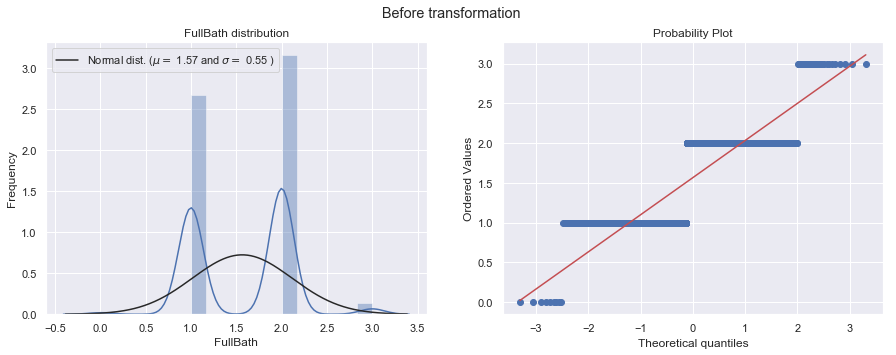

In [41]:
# Testing x Transformation: FullBath

from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['FullBath'] , fit=norm);
(mu, sigma) = norm.fit(df['FullBath'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('FullBath distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['FullBath'], plot=plt)
plt.suptitle('Before transformation')

In [42]:
df.FullBath = np.log1p(df.FullBath)



 mu = 0.92 and sigma = 0.22



Text(0.5, 0.98, 'After transformation')

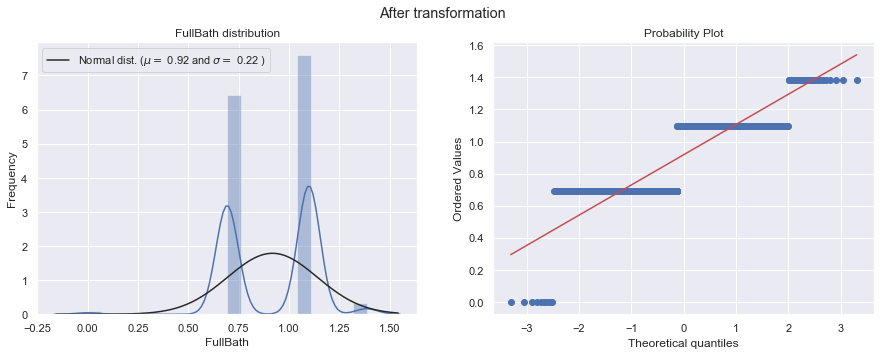

In [43]:
# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['FullBath'] , fit=norm);
(mu, sigma) = norm.fit(df['FullBath'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('FullBath distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['FullBath'], plot=plt)
plt.suptitle('After transformation')


 mu = 1971.27 and sigma = 30.19



Text(0.5, 0.98, 'Before transformation')

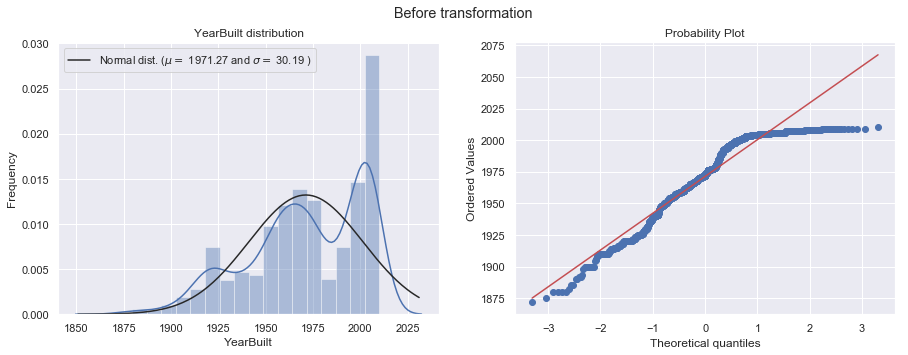

In [44]:
# Testing x Transformation: YearBuilt

from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['YearBuilt'] , fit=norm);
(mu, sigma) = norm.fit(df['YearBuilt'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('YearBuilt distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['YearBuilt'], plot=plt)
plt.suptitle('Before transformation')

In [45]:
df.YearBuilt = np.log1p(df.YearBuilt)



 mu = 7.59 and sigma = 0.02



Text(0.5, 0.98, 'After transformation')

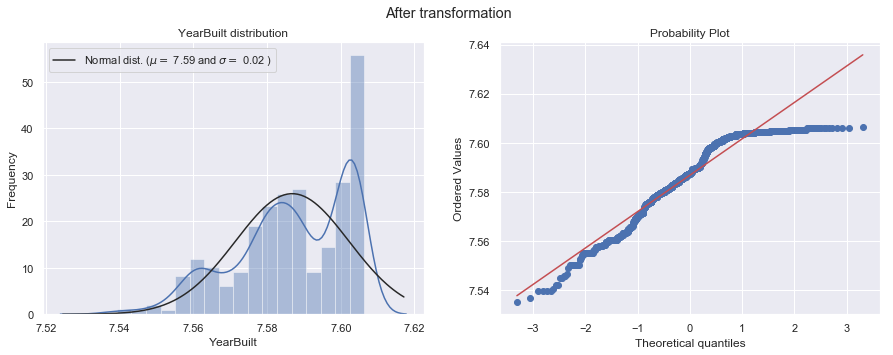

In [46]:
# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['YearBuilt'] , fit=norm);
(mu, sigma) = norm.fit(df['YearBuilt'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('YearBuilt distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['YearBuilt'], plot=plt)
plt.suptitle('After transformation')


 mu = 1976.51 and sigma = 26.30



Text(0.5, 0.98, 'Before transformation')

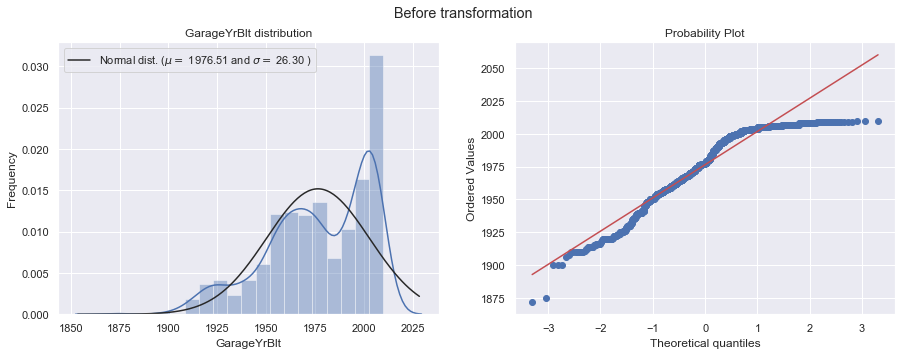

In [47]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['GarageYrBlt'] , fit=norm);
(mu, sigma) = norm.fit(df['GarageYrBlt'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GarageYrBlt distribution')
plt.subplot(1,2,2)
res = stats.probplot(df['GarageYrBlt'], plot=plt)
plt.suptitle('Before transformation')